In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dim)
        self.linear3 = nn.Linear(512, latent_dim)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape) # Reparametrization trick
        self.kl = (0.5 * (sigma**2 + mu**2 - torch.log(sigma**2) - 1)).sum()
        return z

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dim, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [5]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [6]:
def train(variational_autoencoder, data, epochs=20):
    opt = torch.optim.Adam(variational_autoencoder.parameters())
    for epoch in range(epochs):
        running_loss = 0
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = variational_autoencoder(x)
            loss = ((x - x_hat)**2).sum() + variational_autoencoder.encoder.kl
            running_loss += loss.item()
            loss.backward()
            opt.step()
            
        print(f"Epoch: {epoch} - Loss: {running_loss/len(data)}") # Avg loss in epoch
    return variational_autoencoder

In [7]:
latent_dim = 2
variational_autoencoder = VariationalAutoencoder(latent_dim).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=256,
        shuffle=True)

variational_autoencoder = train(variational_autoencoder, data)

Epoch: 0 - Loss: 13393.009549534574
Epoch: 1 - Loss: 11059.369619556184
Epoch: 2 - Loss: 10699.561996135306
Epoch: 3 - Loss: 10518.02532621343
Epoch: 4 - Loss: 10374.656229222075
Epoch: 5 - Loss: 10264.622562749335
Epoch: 6 - Loss: 10166.356346617355
Epoch: 7 - Loss: 10088.041155875997
Epoch: 8 - Loss: 10018.391331449468
Epoch: 9 - Loss: 9966.861449675864
Epoch: 10 - Loss: 9919.990007895613
Epoch: 11 - Loss: 9881.931085854389
Epoch: 12 - Loss: 9843.623169464761
Epoch: 13 - Loss: 9814.980210064827
Epoch: 14 - Loss: 9781.288268783244
Epoch: 15 - Loss: 9758.950070644947
Epoch: 16 - Loss: 9734.720617935505
Epoch: 17 - Loss: 9710.652714635971
Epoch: 18 - Loss: 9692.629223113365
Epoch: 19 - Loss: 9667.265178274602


In [8]:
def plot_latent(variational_autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = variational_autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

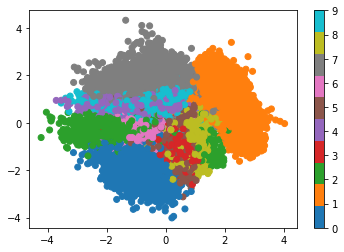

In [9]:
plot_latent(variational_autoencoder, data)

In [10]:
def plot_reconstructed(variational_autoencoder, r0=(-3, 3), r1=(-3, 3), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = variational_autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

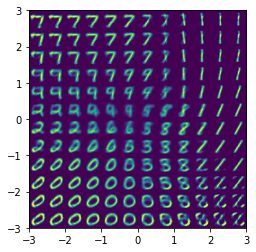

In [11]:
plot_reconstructed(variational_autoencoder)

In [12]:
def interpolate(variational_autoencoder, x_1, x_2, n=12):
    z_1 = variational_autoencoder.encoder(x_1)
    z_2 = variational_autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = variational_autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [13]:
x, y = data.__iter__().next()
x_1 = x[y == 1][1].to(device)
x_2 = x[y == 0][1].to(device)

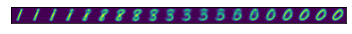

In [14]:
interpolate(variational_autoencoder, x_1, x_2, n=20)

In [15]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)

    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])

    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255

    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning

    images_list[0].save(
        f'{filename}.gif',
        save_all=True,
        append_images=images_list[1:],
        loop=1)

In [16]:
interpolate_gif(variational_autoencoder, "vae", x_1, x_2)

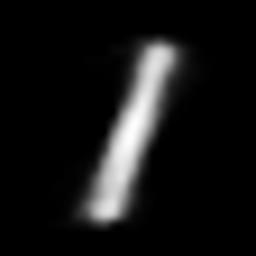

In [17]:
import IPython
gif_file = "vae.gif"
IPython.display.Image(gif_file)